In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers


In [2]:
BATCH_SIZE =32
IMAGE_SIZE =256
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"E:\\IIT M notes\\Non-Core\\Deep Learning Project",
 shuffle = True,
 image_size=(IMAGE_SIZE,IMAGE_SIZE),
 batch_size =BATCH_SIZE)
 


Found 2152 files belonging to 3 classes.


In [4]:
import os
os.getcwd()

'C:\\Users\\Abhijeet Selukar\\Untitled Folder'

In [5]:
class_names = dataset.class_names
print("Class names:", class_names)

Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1]


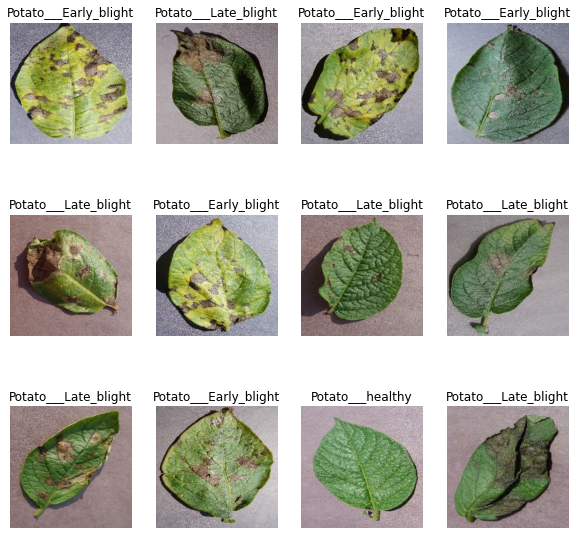

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

68

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
54/54 [==============================] - 170s 3s/step - loss: 0.9259 - accuracy: 0.4618 - val_loss: 0.8781 - val_accuracy: 0.5208
Epoch 2/50
54/54 [==============================] - 128s 2s/step - loss: 0.8558 - accuracy: 0.5307 - val_loss: 0.7088 - val_accuracy: 0.6510
Epoch 3/50
54/54 [==============================] - 131s 2s/step - loss: 0.6552 - accuracy: 0.7182 - val_loss: 0.3894 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 143s 3s/step - loss: 0.3306 - accuracy: 0.8542 - val_loss: 0.3105 - val_accuracy: 0.8594
Epoch 5/50
54/54 [==============================] - 152s 3s/step - loss: 0.2358 - accuracy: 0.9144 - val_loss: 0.2065 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 148s 3s/step - loss: 0.1359 - accuracy: 0.9473 - val_loss: 0.1452 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 135s 2s/step - loss: 0.2791 - accuracy: 0.8860 - val_loss: 0.2262 - val_accuracy: 0.9219
Epoch 8/50
54

In [28]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.77254903 0.74509805 0.77254903]
  [0.74509805 0.7254902  0.7490196 ]
  [0.7372549  0.7176471  0.74509805]
  ...
  [0.5803922  0.5803922  0.6117647 ]
  [0.5803922  0.5803922  0.6117647 ]
  [0.61960787 0.61960787 0.6509804 ]]

 [[0.7647059  0.7372549  0.76862746]
  [0.7411765  0.72156864 0.7490196 ]
  [0.7294118  0.7176471  0.74509805]
  ...
  [0.6039216  0.6039216  0.63529414]
  [0.6117647  0.6117647  0.6431373 ]
  [0.63529414 0.63529414 0.6666667 ]]

 [[0.7254902  0.7019608  0.7411765 ]
  [0.7294118  0.7058824  0.74509805]
  [0.7372549  0.7254902  0.7607843 ]
  ...
  [0.6117647  0.6117647  0.6431373 ]
  [0.6156863  0.6156863  0.64705884]
  [0.6        0.6        0.6313726 ]]

 ...

 [[0.7529412  0.73333335 0.75686276]
  [0.75686276 0.7372549  0.7607843 ]
  [0.7647059  0.74509805 0.76862746]
  ...
  [0.5058824  0.4862745  0.50980395]
  [0.5686275  0.54901963 0.57254905]
  [0.5137255  0.49411765 0.5176471 ]]

 [[0.76862746 0.7490196  0.77254903]
  [0.78431374 0.7647059  0.7882353 ]


In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 58s 751ms/step - loss: 0.0644 - accuracy: 0.9688


In [30]:
scores

[0.06438638269901276, 0.96875]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

50

In [36]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9258809089660645,
 0.8557872176170349,
 0.6551545262336731,
 0.3306378126144409,
 0.23576316237449646]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

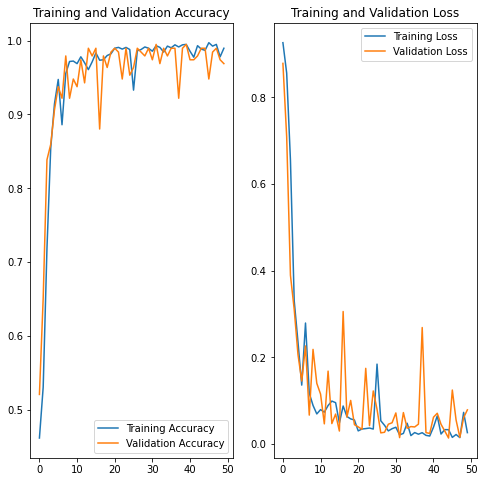

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


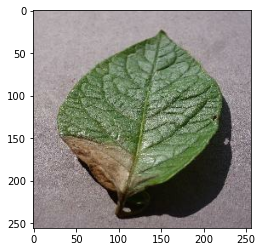

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

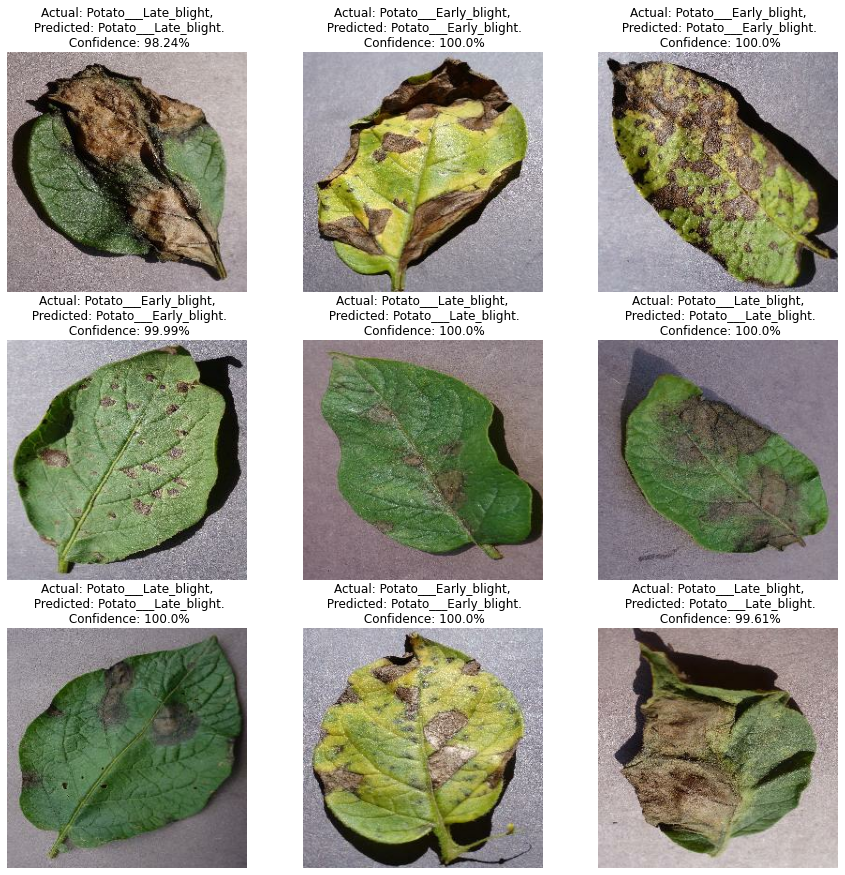

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")